In [1]:
%matplotlib inline
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

import matplotlib.pyplot as plt
import healpy as hp
import numpy as np
import gc

from deepmass import spherical_deepmass as sdm

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


/obs/njeffrey/.local/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/obs/njeffrey/.local/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 1024
  warnings.warn("NSIDE = {0:d}".format(nside))
/obs/njeffrey/.local/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/obs/njeffrey/.local/lib/python3.7/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


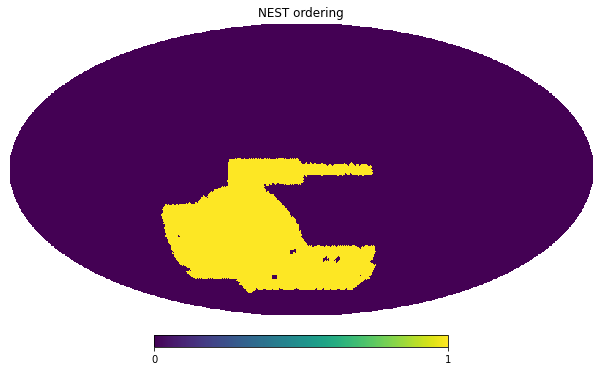

In [2]:
nside = 64
npix = hp.nside2npix(nside=nside)
batch_size = 16
learning_rate = 1e-4


###Importing mask        
mask = hp.read_map('DESY3_sky_mask.fits') # It's in RING ordering
mask = np.ceil(hp.ud_grade(mask,nside))
mask = hp.reorder(mask,r2n=True)

hp.mollview(mask,title='NEST ordering',nest=True)

In [3]:
def power_spectrum(l, A, mu, sigma):
    """Generate power spectrum from gaussian distribution.
    Input:
    l      angular location
    A      amplitude
    simga  standard deviation
    mu     mean
    """
    return A*np.exp((-1/2)*(l-mu)**2/(sigma**2))

indices = np.arange(hp.nside2npix(nside)) # indices of relevant pixels [0, pixels)
l = np.arange(nside)

c_l = power_spectrum(l, 1, 5,25)

n=500 # number of sets 
gaussian_maps = np.array([hp.reorder(hp.synfast(c_l, nside),inp='RING',out='NESTED') for i in range(n)])
#rescale - ensure all values are between 0-1 with average on 0.5.
factor = 20*np.max(np.abs(gaussian_maps))*np.ones(shape=gaussian_maps.shape)
mean = 0.5 #because of last layer having softmax activation, model can't replicate -ve values.
gaussian_maps  = gaussian_maps/factor+mean*np.ones(shape=gaussian_maps.shape)

/obs/njeffrey/.local/lib/python3.7/site-packages/healpy/sphtfunc.py:438: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
/obs/njeffrey/.local/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/obs/njeffrey/.local/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


We build the network with an input shape and print out a summary.

In [4]:
tf.keras.backend.clear_session()

unet_instance = sdm.HealpyUNet(nside, indices, learning_rate, mask, mean, n_neighbors=20)
unet_model = unet_instance.model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 49152, 1)]   0                                            
__________________________________________________________________________________________________
chebyshev (Chebyshev)           (None, 49152, 16)    208         input_1[0][0]                    
__________________________________________________________________________________________________
healpy_pool (HealpyPool)        (None, 12288, 16)    0           chebyshev[0][0]                  
__________________________________________________________________________________________________
chebyshev_1 (Chebyshev)         (None, 12288, 32)    5216        healpy_pool[0][0]                
______________________________________________________________________________________________

We create a dataset for the training with a channel dimension (not strictly necessary if you use the TF routines 
for training) and labels.

We run the model.

In [5]:
tot_train_loss=[]
tot_val_loss=[]

In [6]:
def nested_flip(input_map):
    indices = np.arange(len(input_map))
    nside = hp.npix2nside(len(input_map))
    input_map = hp.reorder(input_map, inp='NEST', out='RING')
    theta, phi = hp.pix2ang(nside= nside, ipix=np.arange(nside*nside*12))
    flipped_indices = hp.ang2pix(nside, np.pi-theta, 2*np.pi - phi)
    input_map = input_map[flipped_indices]
    return hp.reorder(input_map, inp='RING', out='NEST')

def nested_mirror(input_map):
    indices = np.arange(len(input_map))
    nside = hp.npix2nside(len(input_map))
    input_map = hp.reorder(input_map, inp='NEST', out='RING')
    theta, phi = hp.pix2ang(nside= nside, ipix=np.arange(nside*nside*12))
    flipped_indices = hp.ang2pix(nside, np.pi-theta, phi)
    input_map = input_map[flipped_indices]
    return hp.reorder(input_map, inp='RING', out='NEST')

In [7]:
import time

epoch=60
epoch_to_rotate = 5
p=0.95 #train-test split

for k in range(epoch):
    start=time.time()
    
    if (k%5==0) & (k>0):
        print('Rotate, big epoch' + str(k))
        ang1, ang2, ang3 = np.random.uniform(high=360,size=(3,gaussian_maps.shape[0]))
        print(start-time.time())
        t=time.time()
        y = np.array([sdm.rotate(j,ang1[i],ang2[i],ang3[i],nside,p=1) for i,j in enumerate(gaussian_maps)])
    else:
        print(start-time.time())
        t=time.time()
        y = np.copy(gaussian_maps)
        
    
    
    y_mirror = np.array([nested_mirror(y_i) for y_i in y])
    y = np.vstack([y,y_mirror])
    y_mirror = None
    gc.collect()
    y_flip = np.array([nested_flip(y_i) for y_i in y])
    y = np.vstack([y,y_flip])
    y_flip = None
    gc.collect()
    
    print(y.shape)
    print(t-time.time())
    t=time.time()
    
    x = y + np.random.normal(0,0.04,y.shape)

    x = np.array([np.where(mask>0.5,x_i,mean) for x_i in x])
#     y = np.array([np.where(mask>0.5,y_i,mean) for y_i in y])

    x = x.astype(np.float32)[..., None]
    y = y.astype(np.float32)[..., None]
    
    n_train = int(x.shape[0]*p)
    print(t-time.time())
    
    print('Epoch {}/{}'.format(k+1,epoch))
    history = unet_model.fit(
        x=x[:n_train],
        y=y[:n_train],
        batch_size=batch_size,
        epochs=4,
        validation_data=(x[n_train:],y[n_train:])        
    )
    tot_train_loss.append(history.history["loss"][0])
    tot_val_loss.append(history.history["val_loss"][0])

    print(time.time()-start)

-7.152557373046875e-07
(2000, 49152)
-8.319835186004639
-4.657006740570068
Epoch 1/60
Epoch 1/4
119/119 [==============================] - 55s 423ms/step - loss: 0.0205 - val_loss: 0.0093
Epoch 2/4
119/119 [==============================] - 50s 419ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 3/4
119/119 [==============================] - 50s 419ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/4
119/119 [==============================] - 50s 419ms/step - loss: 8.7836e-04 - val_loss: 7.9320e-04
218.0357277393341
-3.5762786865234375e-06
(2000, 49152)
-8.347830057144165
-4.702996253967285
Epoch 2/60
Epoch 1/4
119/119 [==============================] - 50s 418ms/step - loss: 5.5776e-04 - val_loss: 5.4986e-04
Epoch 2/4
119/119 [==============================] - 50s 418ms/step - loss: 4.2746e-04 - val_loss: 4.2267e-04
Epoch 3/4
119/119 [==============================] - 50s 418ms/step - loss: 3.4620e-04 - val_loss: 3.4466e-04
Epoch 4/4
119/119 [==============================] - 50s 418ms/

(2000, 49152)
-51.67696714401245
-4.68766450881958
Epoch 16/60
Epoch 1/4
119/119 [==============================] - 50s 418ms/step - loss: 7.7091e-05 - val_loss: 7.7433e-05
Epoch 2/4
119/119 [==============================] - 50s 418ms/step - loss: 7.7067e-05 - val_loss: 7.6875e-05
Epoch 3/4
119/119 [==============================] - 50s 418ms/step - loss: 7.7238e-05 - val_loss: 8.9918e-05
Epoch 4/4
119/119 [==============================] - 50s 418ms/step - loss: 7.6853e-05 - val_loss: 7.6909e-05
255.78511571884155
-3.0994415283203125e-06
(2000, 49152)
-8.344573736190796
-4.701554775238037
Epoch 17/60
Epoch 1/4
119/119 [==============================] - 50s 418ms/step - loss: 8.0782e-05 - val_loss: 8.7336e-05
Epoch 2/4
119/119 [==============================] - 50s 418ms/step - loss: 8.0879e-05 - val_loss: 8.8496e-05
Epoch 3/4
119/119 [==============================] - 50s 418ms/step - loss: 8.0516e-05 - val_loss: 8.6579e-05
Epoch 4/4
119/119 [==============================] - 50s 418

KeyboardInterrupt: 

A final evaluation on the test set.

In [8]:
unet_model.evaluate(x[n_train:],y[n_train:], batch_size)

7/7 [==============================] - 1s 187ms/step - loss: 7.8476e-05


7.84757430665195e-05

Let's plot the loss.
(Note that the history object contains much more info.)

Text(0, 0.5, 'Loss')

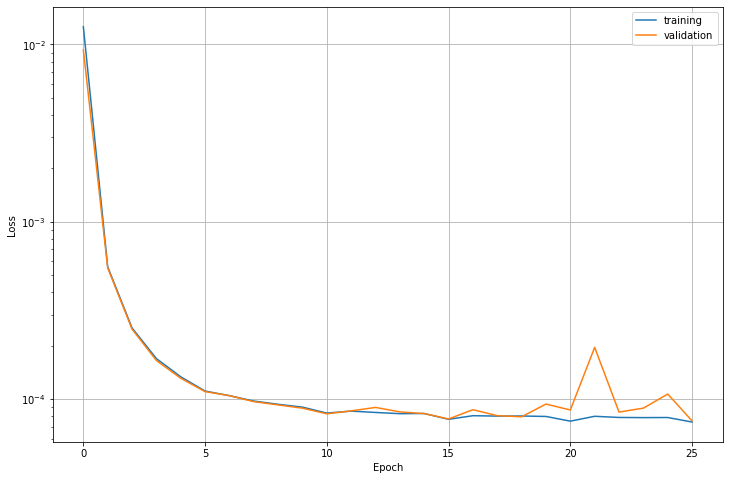

In [9]:
plt.figure(figsize=(12,8))
plt.plot(tot_train_loss, label="training")
plt.plot(tot_val_loss, label="validation")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

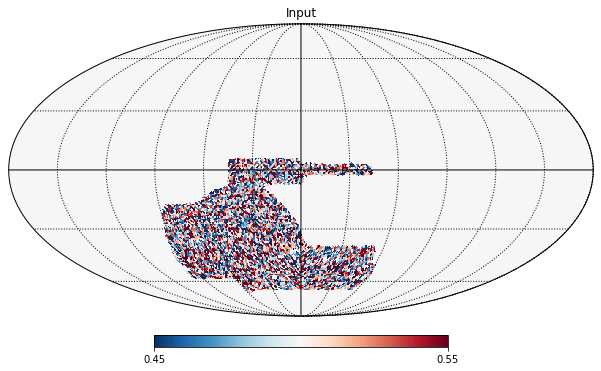

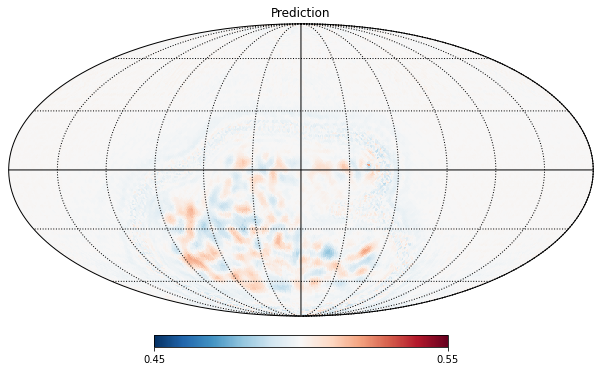

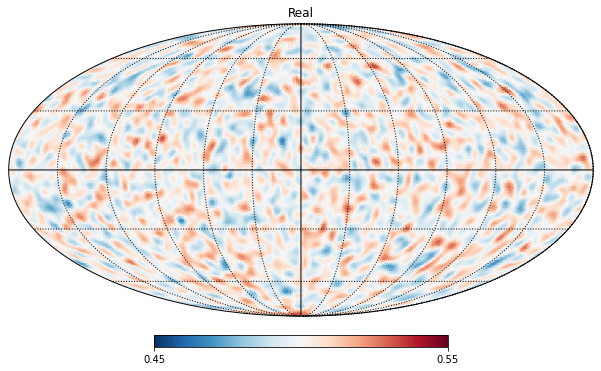

<Figure size 1368x720 with 0 Axes>

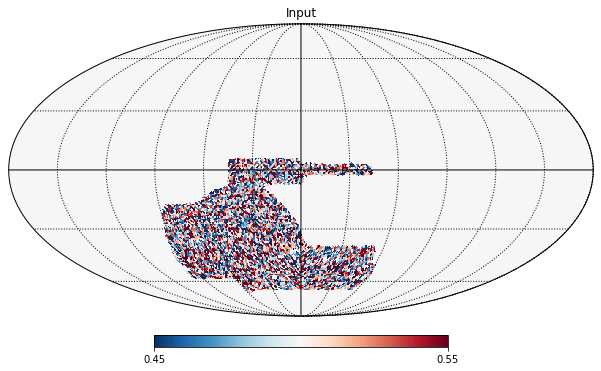

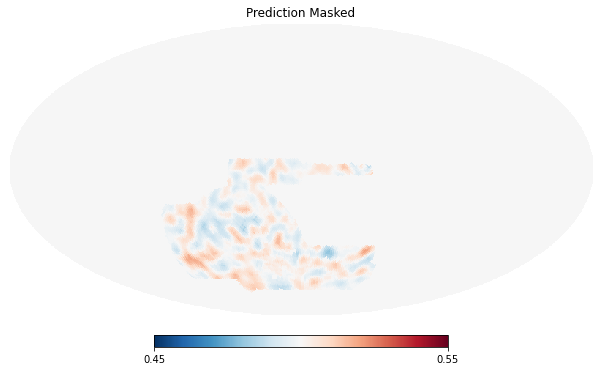

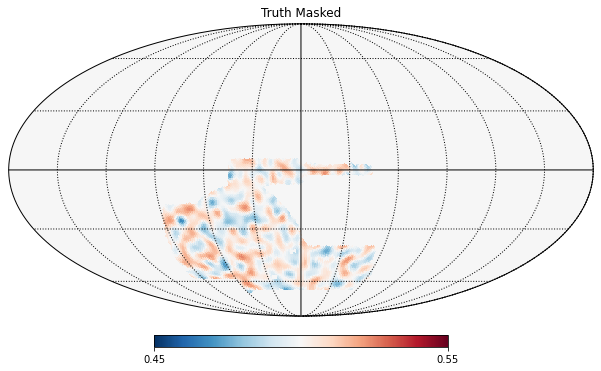

In [13]:
prediction = unet_model.predict(x[-1][None,...])

cm = plt.cm.RdBu_r

hp.mollview(x[-1].flatten(), title='Input', nest=True, cmap=cm, min=.45,max=.55)
hp.graticule()
hp.mollview(prediction[0].flatten(), title='Prediction', nest=True, cmap=cm, min=.45,max=.55)
hp.graticule()
hp.mollview(y[-1].flatten(), title='Real', nest=True, cmap=cm, min=.45,max=.55)
hp.graticule()

prediction = np.array([prediction[0].flatten()])
prediction = np.array([np.where(mask>0.5,x_i,mean) for x_i in prediction])
truth_masked = np.where(mask>0.5,y[-1].flatten(),mean)

plt.figure(figsize=(19,10))
hp.mollview(x[-1].flatten(), title='Input', nest=True, cmap=cm, min=.45,max=.55, sub=(1,3,1))
hp.graticule()
hp.mollview(prediction[0], title='Prediction Masked', nest=True, cmap=cm, min=.45,max=.55, sub=(1,3,2))
hp.mollview(truth_masked, title='Truth Masked', nest=True, cmap=cm, min=.45,max=.55, sub=(1,3,3))
hp.graticule()
plt.savefig('deepmass_sphere.png')
